# Running Exercise 3: Solving the Anastasia Romanov mystery
### Lund University, BINP16: Programming in Python
### Julio Ayala, Pinar Öncel, Mara Vizitiu


## Introduction

## Functions

### Part 1

In [1]:
def score_alignment_identity(seq_1, seq_2, weights):
    '''Function to score an alignment of two sequences
    Arguments:  seq_1, seq_2 (str): sequences, including gaps.
                weights (dict): scores for each case.
    Returns: score and identity of the alignment (tuple)
    '''
    nucleotides = ['A', 'T', 'G', 'C', '?', '-'] # list of all nucleotides
    purines = ['A', 'G']                        # list of purine nucleotides
    pyrimidines = ['T', 'C']                    # list of pyrimidine nucleotides

    score = 0 #Variable to store the score
    identical = 0 #Variable to store the identical nucleotides
    for i in range(len(seq_1)):
        # Add to the score given the different cases
        if (seq_1[i] == seq_2[i]):
            if (seq_1[i] == '-' or seq_1[i] == '?'): #When both are gaps, exclude
                pass
            else:
                score += weights['match']
                identical += 1
        elif (seq_1[i] in purines and seq_2[i] in purines) or (seq_1[i] in pyrimidines and seq_2[i] in pyrimidines):
            score += weights['transition']
        elif (seq_1[i] == '-' or seq_2[i] == '-'):
            score += weights['gap']
        elif (seq_1[i] == '?' or seq_2[i] == '?'): #When one of the nucleotides is
            pass
        else:
            score += weights['transversion']

    identity = round(100 * identical / len(seq_1), 1) # Calculate the identity by dividing identical/length
    return identity, score # Return score and identity as a tuple

In [2]:
def fasta_to_dict(fasta_file):
    '''Function to convert a fasta file into a dictionary
    Arguments: fasta_file, file with fasta sequences, where the header delimiter is >
    Returns: dictionary with ids as keys, and sequences as values
    '''
    sequences = {}
    # Retrieve sequences from the fasta file
    with open(fasta_file, 'r') as fasta:
        for line in fasta:
            if line.startswith('>'): # Get the id from the header and add it to sequence dict
                header = line.strip()[1:]
                sequences[header] = next(fasta).upper().strip()
    return sequences

### Part 2

In [3]:
def msa_to_dict(input_file):    #Function that stores data from the input file into a nested dictionary
    msa_matrix_identity = {}    #Matrix (dictionary of dictionaries) of identity percentages
    msa_matrix_score = {}       #Matrix (dictionary of dictionaries) of alignment scores
    list_of_scores = []         #List of all the alignment scores
    with open(input_file, 'r') as msa_file: #Read the input file
        header = next(msa_file) #Read the header (we do not need the information in the header)
        for line in msa_file:   #Read every line in the input file
            line = line.rstrip().split('\t') # Split the line by its columns and remove new line character
            if line[0] not in msa_matrix_identity: # If the ID does not exist in the dictionary
                msa_matrix_identity[line[0]] = {line[0]: '100'} #Add it with an identity percentage of 100 (when sequence is compared against itself)
                msa_matrix_score[line[0]] = {line[0]: '-'} #Add it without a score ("-") (when compared against itself)
#We add the IDs in the second column of each line to the same dictionary so that the output will be a full, symmetrical matrix. The steps are identical to the ones above
            if line[1] not in msa_matrix_identity: 
                msa_matrix_identity[line[1]] = {line[1]: '100'}
                msa_matrix_score[line[1]] = {line[1]: '-'}
# The identity percentages and the alignment scores are then added to the corresponding dictionaries of dictionaries as values in the nested dictionaries
            msa_matrix_identity[line[0]][line[1]] = line[2].replace('%', '')
            msa_matrix_identity[line[1]][line[0]] = line[2].replace('%', '')
            msa_matrix_score[line[0]][line[1]] = line[3]
            msa_matrix_score[line[1]][line[0]] = line[3]
            list_of_scores.append(int(line[3])) #Add the alignment scores to a list
#Normalizing the values of the alignment scores to add them to the matrix
    min_val = min(list_of_scores)   #Find the smallest alignment score
    max_val = max(list_of_scores)   #Find the largest alignment score
    for key1 in msa_matrix_score:   #Iterate through all the sequence IDs
        for key2 in msa_matrix_score[key1]: #Iterate through all the nested dictionaries
            if msa_matrix_score[key1][key2] != '-': #If a sequence is not compared with itself
                current_value = float(msa_matrix_score[key1][key2]) #Normalize the score value...
                msa_matrix_score[key1][key2] = round(100*(current_value + abs(min_val))/(max_val + abs(min_val)), 1)    #...by adding the absolute value of the smallest score to all scores and then dividing by the largest value. The result is multiplied by 100 to be easier to read as a percentage
            else:   #When the sequence is compared with itself
                msa_matrix_score[key1][key2] = 100  #Set the alignment score to 100
    return msa_matrix_identity, msa_matrix_score

In [4]:
def make_matrix_file(msa_matrix, output_file):
#Function that writes the matrices to the output files
    with open(output_file, 'w') as output_matrix:   #Open the output file for writing
        header = sorted(msa_matrix.keys())  #The first line consists of all the sequence IDs (sorted)
        header_str = '\t' + '\t'.join(header)   #Separate the IDs by tab in the header
        output_matrix.write(header_str + '\n')  #Write the header to the output file
        for key1 in sorted(msa_matrix.keys()):  #Iterate through all the sorted sequence IDs
            output_matrix.write(key1)           #Write one ID at a time to the output file
            for key2 in sorted(msa_matrix[key1]):
                output_matrix.write('\t' + str(msa_matrix[key1][key2])) #Followed by all of the alignment scores between that ID and the other ones, separated by tab
            output_matrix.write('\n')           #Add a new line

In [5]:
def get_most_similar(msa_dict, name):           #Function for finding the most similar sequence to a specific sequence
    max_value = 0                               #Variable that stores the value of the largest alignment score
    max_key = ''                                #Variable that stores the sequence ID corresponding to the largest alignment score
    for key in msa_dict[name].keys():           #Iterate through all the sequence IDs
        if key != name:                         #Exclude the case of a sequence being compared with itself
            if float(msa_dict[name][key]) > max_value:  #If an alignment score is larger than the current largest one being stored in the variable
                max_value = float(msa_dict[name][key])  #Store the new score as the largest
                max_key = key                   #Store the corresponding sequence ID
    return max_key, max_value

### Part 3

In [6]:
def create_clusters(input_file, cluster_method = 'single'):
    '''
    Function to create a hierarchical cluster, given a matrix file. Returns an
    array with the relationships between sequences.
    Arguments:
        input_file: Similarity matrix in a tab delimited file.
        cluster_method: Method used for the linkage function.
    Returns:
        clusters: Array with the scores of relationships among sequences.
        labels: List of labels of the matrix file.
    '''
    #Initializing variables for the parsing of the file.
    data = []
    labels = []
    with open(input_file, 'r') as matrix_file:
        header = next(matrix_file)
        for line in matrix_file:
            line = line.strip().split()
            labels.append(line[0])  # first column is added to the labels
            row = []
            for i in range(1, len(line)):
                row.append(float(line[i]))  #The rest of columns are converted to float and added to the data
            data.append(row)
    # The linkage function is used to create the hierarchical cluster of the given data.
    clusters = linkage(data, method = cluster_method)
    return clusters, labels

## Execution

Importing modules and setting relative paths to files 

In [7]:
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

base_path = os.getcwd() + '/'

mtdna_fasta = os.path.join(base_path, "data/mtdna_orig.fasta")
ychr_fasta = os.path.join(base_path, "data/y_chromosome_orig.fasta")
mtdna_scores_file = os.path.join(base_path, "results/MSAmtdna.txt")
ychr_scores_file = os.path.join(base_path, "results/MSAYchr.txt")
mtdna_id_matrix_file = os.path.join(base_path, "results/output_id_mtdna.txt")
ychr_id_matrix_file = os.path.join(base_path, "results/output_id_ychr.txt")
mtdna_score_matrix_file = os.path.join(base_path, "results/output_score_mtdna.txt")
ychr_score_matrix_file = os.path.join(base_path, "results/output_score_ychr.txt")

### Part I: Calculate all sequence combinations identity and raw scores.

In [8]:
# Dictionary for weights file
weights = {}
with open(os.path.join(base_path, "data/weights.txt"), 'r') as weight_file: # Open a weights file and
    for line in weight_file:
        line = line.split()
        weights[line[0]] = int(line[1])
print(weights)

{'match': 1, 'transition': -1, 'transversion': -2, 'gap': -1}


#### Parsing the sequence files

In [9]:
# Converting fasta files to dictionaries
fasta_dict_mtdna = fasta_to_dict(mtdna_fasta)
fasta_dict_ychr = fasta_to_dict(ychr_fasta)

In [10]:
fasta_dict_mtdna

{'Princess_Irene': 'ACC??TAGCTAGCTAGCATAGCTAGC',
 'Prince_Fred': 'AGGGAT??CTAGCTAGCATAGCTAGC',
 'Nicholas_II_Romanov': '-----GGGG-----AAA---------',
 'Alexandra_Romanov': 'AC---A----A---AGCA---?TA?C',
 'Olga_Romanov': 'AGGG???---AGCTA--ATAG?TAGC',
 'Tatiana_Romanov': 'AGG-------A------------AGC',
 'Maria_Romanov': 'ACC--TAGCT???TAGCAT?GCT---',
 'Alexei_Romanov': 'ACC???AGCTAGCT----TAGCTTTT',
 'Suspected_Anastasia': '??CAGAGACTCTC???CAAAGCTAGC',
 'Anastasia1': 'ACTGTACGCCA??TAAGCA?G??A?C',
 'Anastasia2': 'AGGG???GCT???TA????AGGGGAC',
 'Anastasia3': 'ACC???AGC????GGGCATA??AATT',
 'Anastasia4_son': 'AACAGAGACTAAA???CAAAGCTAGC',
 'Anastasia5': '???AGAGACT??CTCTCAAAGCT---',
 "Farmer's_grandson": 'ACCAA??GCTAA?TAGCAT-GCT--G',
 'Grigori_Rasputin': 'AAAAAGGGGGGGGGCCCCCTATATAT'}

In [11]:
fasta_dict_ychr

{'Prince_Fred_Y': 'AGCCTAGCTCGCGCGCGCATATAGCTAGACTAGCATCGAGAGAGAGAG',
 'Nicolhas_II_Romanov_Y': 'AAAA-----------AAAA--------------GGGGG-----TTT--',
 'Alexei_Romanov_Y': 'AAAA---GAT-CCC-AACA-CGGG-----CGC-GGGGG---CGT----',
 'Anastasia4_son_Y': 'AGCGCATATACGATCGATCAGCTGCATCGACTAGCATCGATACGATCG',
 'Farmer’s_grandson_Y': '?????TATACGCGAAACGATCAGCATGGGTATAGCGCGCTAAGCAT??',
 'Grigori_Rasputin_Y': 'ATATATATACGCGCTACGATCAGCATATATATAGCGCGCTAAGCATCG'}

#### Calculating scores
Once both files are in a dictionary format, the identity and scores are calculated for all pairs of sequences, and written to a file.

In [12]:
# mtDNA file
with open(mtdna_scores_file, 'w') as output_file:
    output_file.write('SmpA\tSmpB\tId_s\tAl_s\n')
    for i, (key_1, seq_1) in enumerate(fasta_dict_mtdna.items()): # Get and index, and items from dict.
        for j, (key_2, seq_2) in enumerate(fasta_dict_mtdna.items()):
            if i < j: # Compare with non-repeating sequences
                # Calculate scores and add to file
                iden, score_seq = score_alignment_identity(seq_1, seq_2, weights)
                output_file.writelines('{}\t{}\t{}%\t{}\n'.format(key_1, key_2, iden, score_seq))
# Y chromosome file
with open(ychr_scores_file, 'w') as output_file:
    output_file.write('SmpA\tSmpB\tId_s\tAl_s\n')
    for i, (key_1, seq_1) in enumerate(fasta_dict_ychr.items()): # Get and index, and items from dict.
        for j, (key_2, seq_2) in enumerate(fasta_dict_ychr.items()):
            if i < j: # Compare with non-repeating sequences
                # Calculate scores and add to file
                iden, score_seq = score_alignment_identity(seq_1, seq_2, weights)
                output_file.writelines('{}\t{}\t{}%\t{}\n'.format(key_1, key_2, iden, score_seq))

### Part 2: Generating similarity matrices

In [13]:
identity_mtdna, score_mtdna = msa_to_dict(mtdna_scores_file)  #Calling the function for the input file; two matrices are returned
identity_ychr, score_ychr = msa_to_dict(ychr_scores_file)

In [14]:
make_matrix_file(identity_mtdna, mtdna_id_matrix_file)         #Write the percentage identity matrix to one output file by calling the proper function
make_matrix_file(score_mtdna, mtdna_score_matrix_file)            #Write the normalized score matrix to another output file by calling the proper function
make_matrix_file(identity_ychr, ychr_id_matrix_file)
make_matrix_file(score_ychr, ychr_score_matrix_file)


### Part 3: Building the hierarchical clusters and dendograms

In [15]:
# Build the clusters for all 4 matrix files
clusters_id_ychr, labels_id_ychr = create_clusters(ychr_id_matrix_file, 'single')
clusters_score_ychr, labels_score_ychr = create_clusters(ychr_score_matrix_file, 'single')
clusters_id_mtdna, labels_id_mtdna = create_clusters(mtdna_id_matrix_file, 'single')
clusters_score_mtdna, labels_score_mtdna = create_clusters(mtdna_score_matrix_file, 'single')

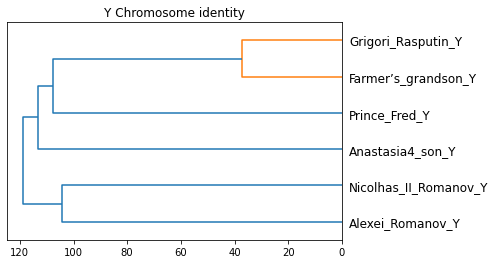

In [16]:
# Create dendogram for the Y Chromosome identity matrix
plt.title('Y Chromosome identity')
dendrogram(clusters_id_ychr
           , labels=labels_id_ychr
           , orientation = 'left') # Setting orientation of the labels/tree

plt.show() # Plotting the figure

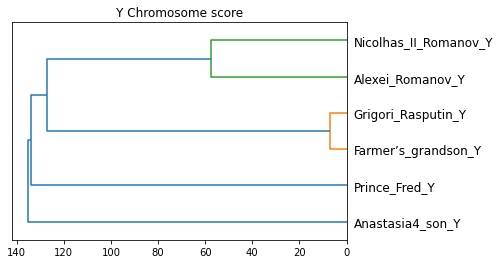

In [17]:
# Create dendogram for the Y Chromosome scoring matrix
plt.title('Y Chromosome score')
dendrogram(clusters_score_ychr
           , labels=labels_score_ychr
           , orientation = 'left')
plt.show()

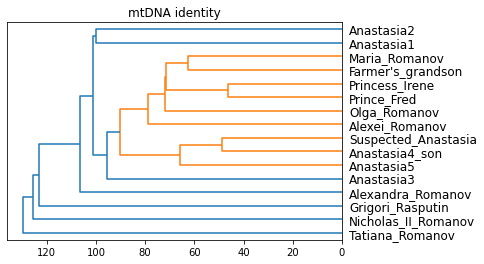

In [18]:
# Create dendogram for the mtDNA identity matrix
plt.title('mtDNA identity')
dendrogram(clusters_id_mtdna
            , labels=labels_id_mtdna
            , orientation = 'left')
plt.show()

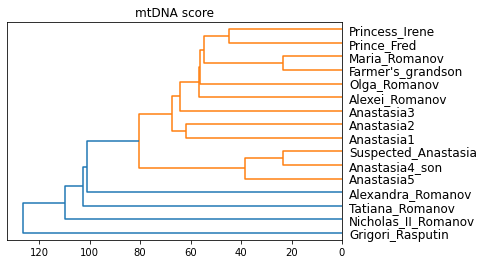

In [19]:
# Create dendogram for the mtDNA scoring matrix
plt.title('mtDNA score')
dendrogram(clusters_score_mtdna
            , labels=labels_score_mtdna
            , orientation = 'left')
plt.show()

## Analysis